# Tutorial - MTMR evaluation

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.evaluate import evaluate_metric
from MTMR.properties import drd2, mcs_similarity

## 2. Specify a target property

In [4]:
PROPERTY_NAME = "drd2"
SCORING_FT = drd2

## 3. Set directories (for inputs and outputs)

In [5]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_our_dir = f"outputs_5-3_{PROPERTY_NAME.upper()}_translation"

In [6]:
output_dir = f"outputs_5-4_{PROPERTY_NAME.upper()}_evaluation"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 4. Load training and test datasets

In [7]:
filepath_train_rdkit = os.path.join(input_data_dir, "rdkit_train_pairs.txt")
filepath_test_rdkit = os.path.join(input_data_dir, "rdkit_test.txt")

In [8]:
df_pairs_rdkit = pd.read_csv(filepath_train_rdkit, header=None, sep=" ")
targets_rdkit = set(df_pairs_rdkit.iloc[:,1].values.tolist())

In [9]:
df_test_rdkit = pd.read_csv(filepath_test_rdkit, header=None, sep=" ")
df_test_rdkit.loc[:,1] = 0.

for i in tqdm.trange(len(df_test_rdkit)):
    smi = df_test_rdkit.iloc[i,0]
    score = SCORING_FT(smi)
    df_test_rdkit.iloc[i,1] = score

100%|██████████| 1000/1000 [00:03<00:00, 259.23it/s]


In [10]:
src2prop = {smi:prop for smi, prop in df_test_rdkit.values}

## 5. Load translation results generated from the test dataset

In [11]:
filepath_MTMR_00 = os.path.join(f"{input_our_dir}_00",  f"MTMR_{PROPERTY_NAME.upper()}.csv") # none of both
filepath_MTMR_01 = os.path.join(f"{input_our_dir}_01",  f"MTMR_{PROPERTY_NAME.upper()}.csv") # no contractive
filepath_MTMR_10 = os.path.join(f"{input_our_dir}_10",  f"MTMR_{PROPERTY_NAME.upper()}.csv") # no margin
filepath_MTMR_11 = os.path.join(f"{input_our_dir}_11",  f"MTMR_{PROPERTY_NAME.upper()}.csv") # control

In [12]:
df_MTMR_00 = pd.read_csv(filepath_MTMR_00,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_MTMR_01 = pd.read_csv(filepath_MTMR_01,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_MTMR_10 = pd.read_csv(filepath_MTMR_10,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_MTMR_11 = pd.read_csv(filepath_MTMR_11,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})

In [13]:
frames_models = [('MTMR_00', df_MTMR_00),
                 ('MTMR_01', df_MTMR_01),
                 ('MTMR_10', df_MTMR_10),
                 ('MTMR_11', df_MTMR_11)]

In [14]:
for name, df in frames_models:
    df.loc[:,"PROPERTY_SRC"] = 0.
    for i in tqdm.trange(len(df)):
        smi_src = df.loc[i,"SOURCE"]
        smi_tar = df.loc[i,"TARGET"]
        df.loc[i,"PROPERTY_SRC"] = src2prop.get(smi_src)

100%|██████████| 20000/20000 [00:03<00:00, 5856.42it/s]


## 6. Evaluate metrics

In [15]:
frames = []
thresholds_sim = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for i in tqdm.trange(len(frames_models)):
    name, df = frames_models[i]
    for threshold_sim in thresholds_sim:
        df_metric = evaluate_metric(df, targets_rdkit, num_decode=20,# sample_size=10, start_idx=10,
                                    threshold_sim=threshold_sim,
                                    threshold_pro=0.9, threshold_improve=0).rename(columns={0:name})

        df_metric.loc["THRESHOLD_SIMILARITY",name] = threshold_sim
        frames.append(df_metric)

100%|██████████| 4/4 [01:55<00:00, 28.88s/it]


In [16]:
df_merged = pd.concat(frames, axis=1).T

In [17]:
df_merged

,VALID_RATIO,PROPERTY,IMPROVEMENT,SIMILARITY,NOVELTY,SUCCESS_PROP,SUCCESS_IMPR,DIVERSITY,THRESHOLD_SIMILARITY
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.388,0.120665,0.40
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.366,0.120665,0.45
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.339,0.120665,0.50
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.304,0.120665,0.55
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.267,0.120665,0.60
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.001,0.212,0.120665,0.65
MTMR_00,0.608,0.011803,0.007395,0.347499,0.608,0.000,0.160,0.120665,0.70
MTMR_01,0.589,0.011593,0.007140,0.342134,0.589,0.000,0.387,0.116732,0.40
MTMR_01,0.589,0.011593,0.007140,0.342134,0.589,0.000,0.373,0.116732,0.45
MTMR_01,0.589,0.011593,0.007140,0.342134,0.589,0.000,0.348,0.116732,0.50


In [18]:
df_merged.to_csv(os.path.join(output_dir, "table_metrics.csv"))

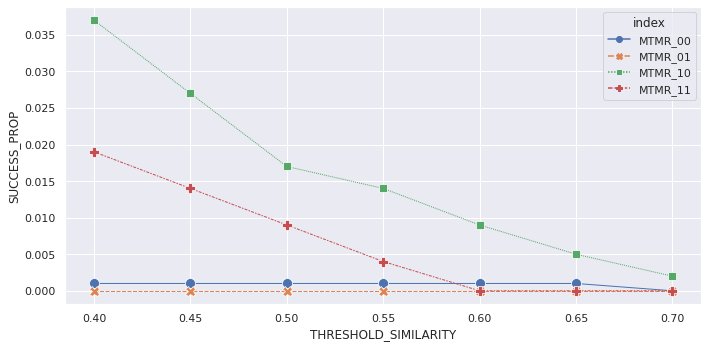

In [21]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(10,5))

_ = sns.lineplot(data=df_merged.reset_index(),
                 x='THRESHOLD_SIMILARITY', y="SUCCESS_PROP", hue="index",
                 style="index", markers=True, linewidth=1, markersize=10,
                 ax=ax)

#ax.set_ylim(None, 0.45)

plt.tight_layout()
plt.show()

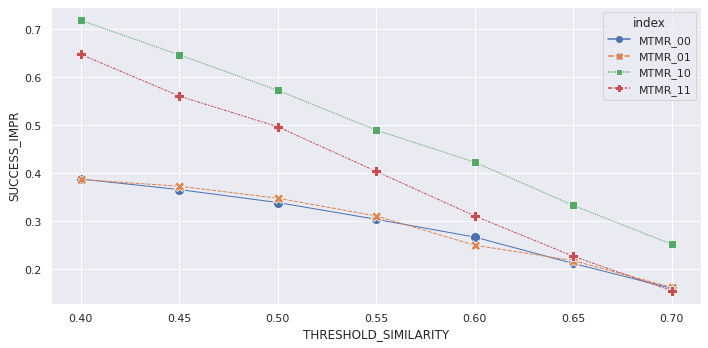

In [20]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(10,5))

_ = sns.lineplot(data=df_merged.reset_index(),
                 x='THRESHOLD_SIMILARITY', y="SUCCESS_IMPR", hue="index",
                 style="index", markers=True, linewidth=1, markersize=10,
                 ax=ax)

#ax.set_ylim(None, 0.45)

plt.tight_layout()
plt.show()

In [23]:
df_merged.loc[:,["PROPERTY", "IMPROVEMENT", "SIMILARITY"]].drop_duplicates()

,PROPERTY,IMPROVEMENT,SIMILARITY
MTMR_00,0.011803,0.007395,0.347499
MTMR_01,0.011593,0.007140,0.342134
MTMR_10,0.066008,0.059354,0.435009
MTMR_11,0.045610,0.038985,0.389571


## 7. Property distribution

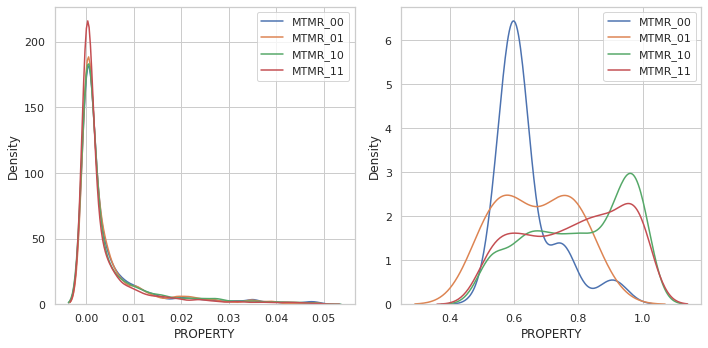

In [22]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,2,figsize=(10,5))

for name, df in frames_models:
    idx = df.loc[:,"PROPERTY"] <= 0.05
    _ = sns.kdeplot(data=df[idx], x="PROPERTY", label=name, ax=ax[0])
    
    idx = df.loc[:,"PROPERTY"] >= 0.5
    _ = sns.kdeplot(data=df[idx], x="PROPERTY", label=name, ax=ax[1])
    
#ax.set_yscale('log')
#ax.set_ylim(0.01,None)

ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()